In [17]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error



# 1. Random Forest Regression Tree

Prepare data

In [18]:
#Load Data
df = pd.read_csv('train_data.csv')

#Prepare Features and Target
X = df.drop('resale_price', axis=1)
y = df['resale_price']

#Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [11]:
print(df.shape)

(157060, 18)


In [15]:
df_trial = pd.read_csv('data/train_data.csv')
print(df_trial.shape)

(51658, 113)


Initialize and Evaluate first round of Decision Tree

In [19]:
# Convert the 'date' column to numeric format (e.g., timestamp)
X_train['date'] = pd.to_datetime(X_train['date']).astype(int) / 10**9
X_test['date'] = pd.to_datetime(X_test['date']).astype(int) / 10**9

# Initialize and Train a Decision Tree
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate Decision Tree
y_pred_dt = dt_model.predict(X_test)
print(f'Decision Tree MAE: {mean_absolute_error(y_test, y_pred_dt):.2f}')
print(f'Decision Tree R²: {r2_score(y_test, y_pred_dt):.2f}')

Decision Tree MAE: 93047.43
Decision Tree R²: 0.48


Visualize the Decision Tree (Simplified)

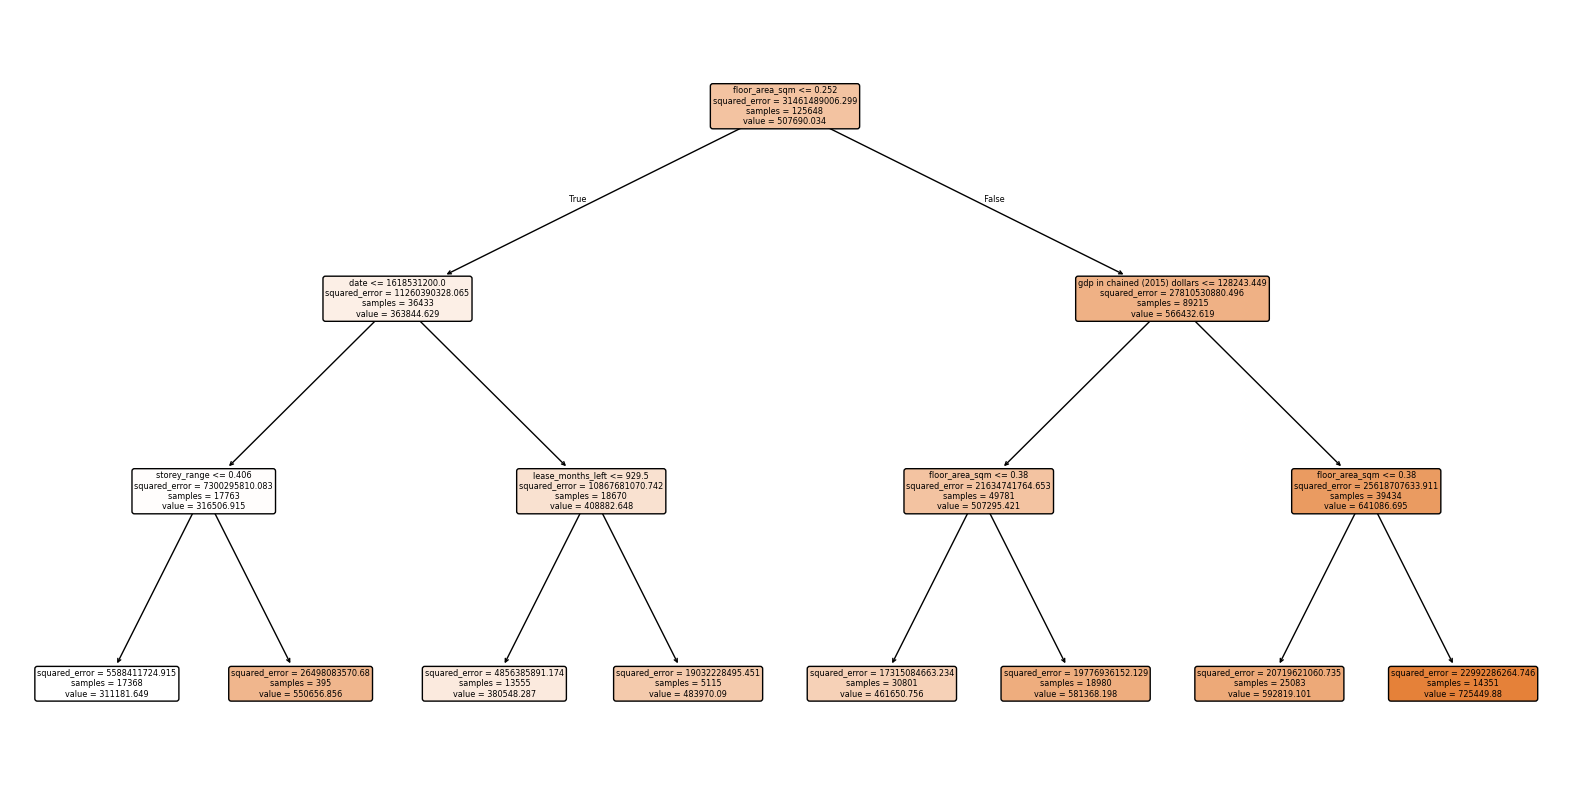

RandomForestRegressor(random_state=42)

In [9]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns.tolist(), filled=True, rounded=True)
plt.show()

#Initialize and Train a Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

### Random Search (Hyperparameter Tuning)

In [6]:
# Decision Tree Hyperparameters
dt_param_dist = {
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

dt_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_
print("Best Decision Tree Parameters:", dt_search.best_params_)

# Random Forest Hyperparameters
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest Parameters:", rf_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Decision Tree Parameters: {'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'bootstrap': True}



Tuned Decision Tree Performance:
MAE: 54884.58
MSE: 7000460933.66
R²: 0.78

Tuned Random Forest Performance:
MAE: 49266.85
MSE: 5678399788.54
R²: 0.82

Top 10 Features (Tuned Random Forest):
                          Feature  Importance
1                  floor_area_sqm    0.474634
2               lease_months_left    0.135970
0                    storey_range    0.120436
8                      m_from2017    0.059428
3                            date    0.055073
7      mas core inflation measure    0.049322
15                flat_model_DBSS    0.023551
6                     liabilities    0.015088
13                  town_sengkang    0.014856
4   gdp in chained (2015) dollars    0.013304


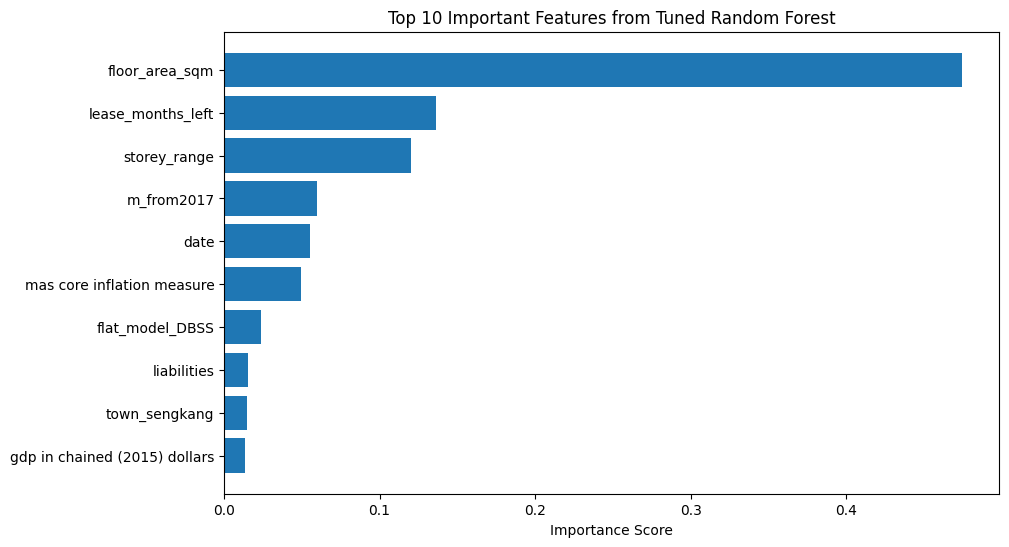

In [7]:
# Tuned Decision Tree
y_pred_dt_tuned = best_dt.predict(X_test)
print('\nTuned Decision Tree Performance:')
print(f'MAE: {mean_absolute_error(y_test, y_pred_dt_tuned):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_pred_dt_tuned):.2f}')
print(f'R²: {r2_score(y_test, y_pred_dt_tuned):.2f}')

# Tuned Random Forest
y_pred_rf_tuned = best_rf.predict(X_test)
print('\nTuned Random Forest Performance:')
print(f'MAE: {mean_absolute_error(y_test, y_pred_rf_tuned):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_pred_rf_tuned):.2f}')
print(f'R²: {r2_score(y_test, y_pred_rf_tuned):.2f}')

# Update Feature Importance to use tuned model (Replace original Step 11)
# Step 13: Feature Importance Analysis with Tuned Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features (Tuned Random Forest):")
print(feature_importance.head(10))

# Step 14: Visualize Feature Importance (Updated)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features from Tuned Random Forest')
plt.xlabel('Importance Score')
plt.show()

Plot Residuals

Residuals:


# xgboost and Adaboost

In [8]:
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [ ]:
# Define the parameter distribution for XGBoost
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initialize RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the random search on the training data
xgb_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_xgb_params = xgb_search.best_params_
best_xgb_model = xgb_search.best_estimator_

print("Best XGBoost Parameters:", best_xgb_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [26]:
# Initialize the XGBoost model with the best parameters
xgb_best_model = XGBRegressor(
    subsample=1.0,
    n_estimators=200,
    min_child_weight=5,
    max_depth=15,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.6,
    random_state=42
)

# Train the model on the training data
xgb_best_model.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb_best = xgb_best_model.predict(X_test)

# Evaluate the model
print('\nXGBoost (Best Parameters) Performance:')
print(f'MSE: {mean_squared_error(y_test, y_pred_xgb_best):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_xgb_best):.2f}')
print(f'R²: {r2_score(y_test, y_pred_xgb_best):.2f}')


XGBoost (Best Parameters) Performance:
MSE: 5290542302.12
MAE: 47909.76
R²: 0.83


In [ ]:
# XGBoost Model (without hyperparameter tuning)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print('\nXGBoost Performance:')

print(f'MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}')
print(f'R²: {r2_score(y_test, y_pred_xgb):.2f}')


XGBoost Performance:
MSE: 5945716388.22
MAE: 52330.37
R²: 0.81


In [22]:
#Hyperparameter Tuning for Adaboost

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Initialize the AdaBoost model
ada_model = AdaBoostRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_ada_model = grid_search.best_estimator_



Tuned AdaBoost Performance:
MSE: 13688120170.29
R²: 0.57
MAE: 92651.79


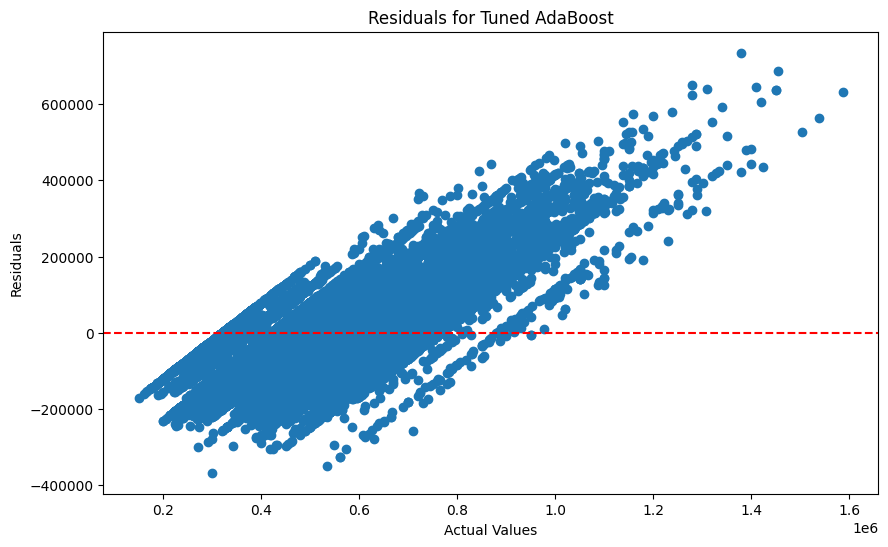

In [23]:
# Predict using the best model
y_pred_ada_tuned = best_ada_model.predict(X_test)

# Evaluate the tuned model
print('\nTuned AdaBoost Performance:')
print(f'MSE: {mean_squared_error(y_test, y_pred_ada_tuned):.2f}')
print(f'R²: {r2_score(y_test, y_pred_ada_tuned):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred_ada_tuned):.2f}')

# Residuals for Tuned AdaBoost
residuals_ada_tuned = y_test - y_pred_ada_tuned
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_ada_tuned)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Tuned AdaBoost')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

In [33]:
# Calculate performance metrics for each model
metrics = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost'],
    'R²': [
        r2_score(y_test, y_pred_dt_tuned),
        r2_score(y_test, y_pred_rf_tuned),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_ada_tuned)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_dt_tuned),
        mean_absolute_error(y_test, y_pred_rf_tuned),
        mean_absolute_error(y_test, y_pred_xgb),
        mean_absolute_error(y_test, y_pred_ada_tuned)
    ],
    'MSE': [
        mean_squared_error(y_test, y_pred_dt_tuned),
        mean_squared_error(y_test, y_pred_rf_tuned),
        mean_squared_error(y_test, y_pred_xgb),
        mean_squared_error(y_test, y_pred_ada_tuned)
    ]
}

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics)

# Print the DataFrame
print(metrics_df)

           Model        R²           MAE           MSE
0  Decision Tree  0.932643  31163.032407  2.147915e+09
1  Random Forest  0.958874  25091.139714  1.311438e+09
2        XGBoost  0.950964  28454.018461  1.563698e+09
3       AdaBoost  0.564286  93600.787881  1.389429e+10
